# Recommender System using Collaborative Filtering

DATA: Spotify Song Ratings  
User-based collaborative filtering via Matrix Factorization

### Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load our spotify data

df = pd.read_csv('starRatings.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0
3,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# EDA
num_users = df.shape[0]
print('number of users:', num_users)
num_songs = df.shape[1]
print('number of songs:', num_songs)
num_ratings = df.count().sum()
print('total num of ratings', num_ratings)

number of users: 10000
number of songs: 5000
total num of ratings 4996173


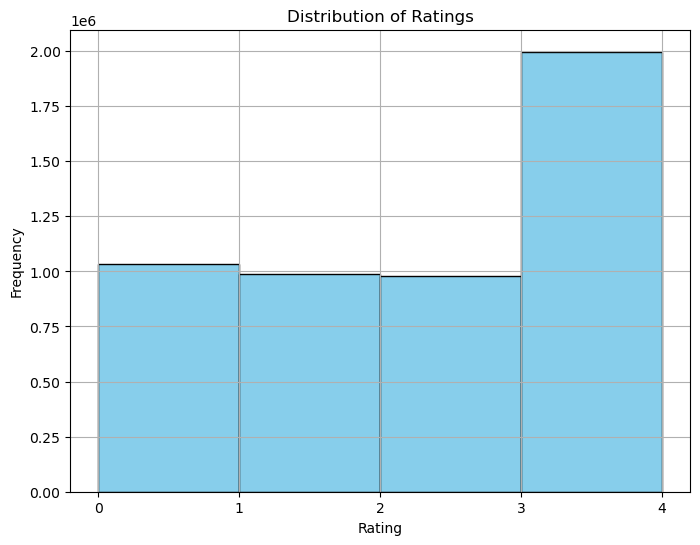

In [4]:
# Visual
ratings = df.values.flatten()

# remove nans
ratings = ratings[~np.isnan(ratings)]

# plot
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=np.arange(min(ratings), max(ratings) + 1, 1), edgecolor='black', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(int(min(ratings)), int(max(ratings)) + 1))
plt.grid(True)
plt.show()

In [5]:
# check user-item sparsity
total_possible_ratings = num_users * num_songs
sparsity = 1 - (num_ratings / total_possible_ratings)
print(f"Sparsity of the user-song matrix: {sparsity:.2%}")

Sparsity of the user-song matrix: 90.01%


For the purpose of training, we will convert DataFrame into a long-format (user-item-rating triplets)

In [6]:
# Assign colunm names and user ids as index

df.columns = [i+1 for i in range(df.shape[1])]
df.index = [i+1 for i in range(df.shape[0])]


# Melt the df to a long-format
df_long = df.reset_index().melt(id_vars='index', var_name='song',value_name='rating')

# Rename the 'index' column to 'user'
df_long.rename(columns={'index': 'user'}, inplace=True)

# Filter out Nans
df_long = df_long[df_long['rating'] > 0]

# reset index for cleaningness
df_long.reset_index(drop=True, inplace=True)

In [19]:
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm


In [8]:
# PyTorch embedding layers requires continues index starting from 0
# Using sklearn labelencoder to map the user-item index
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_long['user_id'] = user_encoder.fit_transform(df_long['user'])
df_long['song_id'] = item_encoder.fit_transform(df_long['song'])

num_users = df_long['user_id'].nunique()
num_items = df_long['song_id'].nunique()


In [11]:
# Convert to numpy format for easier manipulation
ratings = df_long[['user_id','song_id','rating']].to_numpy()

### Model Building

In [33]:
# Define matrixfactorization class
class MatrixFactorization(torch.nn.Module):
    def __init__(self, num_user, num_items, num_factors = 20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(num_users, num_factors)
        # item embeddings
        self.item_factors = torch.nn.Embedding(num_items, num_factors)
    # initalize embedding weights drawn from a normal distribution between 0 - 0.01
        self.user_factors.weight.data.normal_(0, 0.01)
        self.item_factors.weight.data.normal_(0, 0.01)

    def forward(self, user_indices, item_indices):
        # matrix multiplication
        user_vectors = self.user_factors(user_indices)
        item_vectors = self.item_factors(item_indices)

        prediction = (user_vectors * item_vectors).sum(dim=1)
        return prediction
    
    def predict(self, user, item):
        return self.forward(user,item)


In [34]:
# Define dataloder
from torch.utils.data import Dataset, DataLoader

class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.users = torch.tensor(ratings[:, 0], dtype=torch.long)
        self.items = torch.tensor(ratings[:, 1], dtype=torch.long)
        self.ratings = torch.tensor(ratings[:, 2], dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

### Model Training

In [35]:
# Create dataloaders

train_set = RatingsDataset(ratings)
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)


In [36]:
# check for gpu
print('Is running on GPU:',torch.cuda.is_available())

Is running on GPU: True


In [43]:
# Setting up Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setting up model
model = MatrixFactorization(num_users, num_items, num_factors=8)
model.to(device)

print(model)

# print out parameters being optimizted
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Define loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


MatrixFactorization(
  (user_factors): Embedding(10000, 8)
  (item_factors): Embedding(5000, 8)
)
user_factors.weight tensor([[ 0.0078,  0.0101,  0.0032,  ...,  0.0093, -0.0081,  0.0091],
        [ 0.0042, -0.0045,  0.0069,  ...,  0.0019, -0.0014,  0.0002],
        [-0.0058,  0.0039, -0.0002,  ...,  0.0184, -0.0096,  0.0084],
        ...,
        [ 0.0012,  0.0036, -0.0125,  ...,  0.0081,  0.0068, -0.0172],
        [ 0.0076, -0.0045, -0.0122,  ...,  0.0042,  0.0010,  0.0029],
        [ 0.0010, -0.0127, -0.0103,  ...,  0.0138,  0.0086, -0.0088]],
       device='cuda:0')
item_factors.weight tensor([[-0.0183,  0.0155,  0.0004,  ...,  0.0044,  0.0133,  0.0092],
        [ 0.0021, -0.0031, -0.0081,  ..., -0.0053, -0.0024,  0.0111],
        [-0.0096,  0.0017,  0.0042,  ...,  0.0046,  0.0037, -0.0097],
        ...,
        [ 0.0049, -0.0013,  0.0066,  ...,  0.0075,  0.0134,  0.0062],
        [ 0.0035, -0.0018, -0.0113,  ..., -0.0092, -0.0030, -0.0206],
        [ 0.0031,  0.0028, -0.0068,  ...,

In [45]:
# Model trainning 
num_epochs = 128

for epochs in tqdm(range(num_epochs)):
    model.train()
    losses = 0
    for user_batch, item_batch, rating_batch in train_loader:
        user_batch = user_batch.to(device)
        item_batch = item_batch.to(device)
        rating_batch = rating_batch.to(device)

        optimizer.zero_grad()
        predictions = model(user_batch, item_batch)
        loss = loss_function(predictions, rating_batch)
        loss.backward()
        optimizer.step()

        losses += loss.item() * len(rating_batch)

    avg_train_loss = losses / len(train_loader.dataset)

    print(f'Epoch {epochs+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

/tmp/ipykernel_17444/41883211.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epochs in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/128, Training Loss: 0.9623
Epoch 2/128, Training Loss: 0.9431
Epoch 3/128, Training Loss: 0.9431
Epoch 4/128, Training Loss: 0.9429
Epoch 5/128, Training Loss: 0.9429
Epoch 6/128, Training Loss: 0.9426
Epoch 7/128, Training Loss: 0.9423
Epoch 8/128, Training Loss: 0.9420
Epoch 9/128, Training Loss: 0.9411
Epoch 10/128, Training Loss: 0.9396
Epoch 11/128, Training Loss: 0.9364
Epoch 12/128, Training Loss: 0.9301
Epoch 13/128, Training Loss: 0.9205
Epoch 14/128, Training Loss: 0.9103
Epoch 15/128, Training Loss: 0.9028
Epoch 16/128, Training Loss: 0.8983
Epoch 17/128, Training Loss: 0.8948
Epoch 18/128, Training Loss: 0.8918
Epoch 19/128, Training Loss: 0.8890
Epoch 20/128, Training Loss: 0.8863
Epoch 21/128, Training Loss: 0.8840
Epoch 22/128, Training Loss: 0.8819
Epoch 23/128, Training Loss: 0.8804
Epoch 24/128, Training Loss: 0.8791
Epoch 25/128, Training Loss: 0.8781
Epoch 26/128, Training Loss: 0.8773
Epoch 27/128, Training Loss: 0.8767
Epoch 28/128, Training Loss: 0.8763
E

In [49]:
# Save the trained model
torch.save(model.state_dict(), 'matrix_factorization_model.pth')

Furthur tuning of the model will improve the model's performance, MSE of 0.8684 is accecptable here.  
Model Improvement:  
* Tuning the hyperparameters: num_factors, learning rate, add regularization weight_decay.  
* Incorporate Bias Terms to capture outliers.
* Data Normalization: Mean-Centering.


## Generating Recommendations

Approach:  
* Identify items the user has not rated.
* Use the trained model to predict ratings for these items.
* Select the top-N items with the highest predicted ratings.


In [48]:
all_item_indices = torch.arange(num_items, dtype=torch.long).to(device)

In [51]:
from collections import defaultdict

# Build a dictionary where each key is a user_id and the value is a set of item_ids the user has interacted with
known_user_item_pairs = defaultdict(set)
for user_id, item_id, _ in ratings:
    known_user_item_pairs[user_id].add(item_id)

In [56]:
# Defin the recommendation function
def recommend_items(model, user_id_to_predict, known_user_item_pairs, num_recommendations = 10):
    # set model to evaluation mode
    model.eval()

    # Convert user_id to tensor
    user_id = user_id_to_predict - 1

    # Crate a tensor for the user id
    user_tensor = torch.tensor([user_id], dtype=torch.long).to(device)

    # Retrieve the known_items for the user
    known_items = known_user_item_pairs.get(user_id_to_predict, set())

    # Filter out known items
    item_to_predict = [i for i in range(num_items) if i not in known_items]

    # Convert to tensor
    items_to_predict_tensor = torch.tensor(item_to_predict, dtype=torch.long).to(device)

    # Repeat the user tensor to match the size of items_to_predict_tensor
    user_tensor_expanded = user_tensor.repeat(len(items_to_predict_tensor))

    # Use the model to predict ratings 
    with torch.no_grad():
        predictions = model(user_tensor_expanded, items_to_predict_tensor)

    # Get top N items with the highest predicted ratings as recommendations
    top_preds = torch.topk(predictions, num_recommendations)

    # Extract the indices of the recommended items
    recommend_items_indices = items_to_predict_tensor[top_preds.indices].cpu().numpy()

    # Map the encoded items indices back to item IDs
    recommend_item_ids = item_encoder.inverse_transform(recommend_items_indices)

    return recommend_item_ids


In [61]:
# Since our song name is contained in another file we need to extract and form an according dict
df_songs = pd.read_csv('spotify52kData.csv')

# Set song dict
song_names = df_songs.iloc[:5000, 3]
song_ids = range(1, len(song_names) + 1)

# Crate a dict to map song IDs to song names
item_id_to_name = dict(zip(song_ids, song_names))

In [64]:
# Specify the user IDs, dtype = INT
user_ids = [1, 2, 3, 4, 5]  # List of user IDs for whom you want to generate recommendations

# Loop over each user ID to generate recommendations
for user_id in user_ids:
    # Generate recommendations
    recommendations = recommend_items(model, user_id, known_user_item_pairs, num_recommendations=10)
    
    # Print the recommendations
    print(f'\nRecommended items for User {user_id}:')
    for idx, item_id in enumerate(recommendations, 1):
        song_name = item_id_to_name.get(item_id, "Unknown Song")
        print(f"{idx}. {song_name},{item_id}")


Recommended items for User 1:
1. New Gold (feat. Tame Impala and Bootie Brown),3254
2. My God Is Still The Same,2924
3. B.Y.O.B.,3868
4. The Kids Aren't Alright,2771
5. You're Gonna Go Far, Kid,2563
6. You're Gonna Go Far, Kid,3878
7. Toxicity,3455
8. Cult of Personality,3864
9. Californication,2106
10. White Flag,2562

Recommended items for User 2:
1. The Reason,3159
2. You're Gonna Go Far, Kid,2563
3. New Gold (feat. Tame Impala and Bootie Brown),3254
4. Sweater Weather,2004
5. The Kids Aren't Alright,2771
6. Time of Dying,2907
7. Californication,2106
8. Can't Stop,2261
9. Can't Stop,3465
10. Numb,3008

Recommended items for User 3:
1. The 1975,3556
2. Boku no Sensou,3356
3. No Surprises,2056
4. Blood // Water,3013
5. Suddenly I See,138
6. Daddy Issues,3001
7. Born For This,3212
8. Renegades,3311
9. You're Gonna Go Far, Kid,2563
10. Feel Invincible,3266

Recommended items for User 4:
1. Sweater Weather,2004
2. New Gold (feat. Tame Impala and Bootie Brown),3254
3. Can't Stop,3465
4. 